In [ ]:
#import library
import tensorflow as tf
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import time
import json
#mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#check the runtime type
! nvidia-smi
"""
FLAT Dataflow Implementation:
"""
def FlatDataflow(loop_num, query, key, value, bias, batch_granularity_level1=1, batch_granularity_level2=1, head_granularity_level1=16,
                 head_granularity_level2=8, length_granularity_level=64):
  if (tf.config.list_physical_devices('GPU')):
    memory_before = tf.config.experimental.get_memory_info('GPU:0')
    print("Iteration %d: Before running, reset the memory! Memory peak: %f; Memory current: %f"%(loop_num, memory_before['peak'], memory_before['current']))
    batch_size, source_length, head_num, dim = tf.shape(query).numpy()
    #since bias matrix shape is not fixed from time to time, randomly select a number here
    #biasValue = bias[np.random.randint(tf.reshape(bias, [-1, 1]).size())]
    bias_value = bias[0, 0, 0, 0]
    for batch in tf.range(0, batch_size, batch_granularity_level1):
      for head in tf.range(0, head_num, head_granularity_level1):
        batch_termination = batch + batch_granularity_level1 if batch + batch_granularity_level1 <= batch_size else batch_size
        for unit_batch in tf.range(batch, batch_termination, batch_granularity_level2):
          if (batch_granularity_level2 != 1):
            #Lowest granularity is batch level
            end_batch = unit_batch + batch_granularity_level2 if unit_batch + batch_granularity_level2 <= batch_termination else batch_termination
            query_source = tf.gather(query[:, :, :, :], indices=tf.range(unit_batch, end_batch), axis=0)
            print(query_source.shape)
            key_source = tf.gather(key[:, :, :, :], indices=tf.range(unit_batch, end_batch), axis=0)
            value_source = tf.gather(value[:, :, :, :], indices=tf.range(unit_batch, end_batch), axis=0)
            result = tf.einsum("BTNH, BFNH->BNFT", key_source, query_source)
            result += bias_value
            result = tf.nn.softmax(result, name="attention_weights")
            result = tf.nn.dropout(result, rate=0.4)
            attention_output = tf.einsum("BNFT,BTNH->BFNH", result, value_source)
          else:
            head_termination = head + head_granularity_level1 if head + head_granularity_level1 <= head_num else head_num
            for unit_head in tf.range(head, head_termination, batch_granularity_level2):
              #Lowest granularity is head level
              if (head_granularity_level2 != 1):
                end_head = unit_head + head_granularity_level2 if unit_head + head_granularity_level2 <= head_termination else head_termination
                query_source = tf.gather(query[unit_batch, :, :, :], indices=tf.range(unit_head, end_head), axis=1)
                key_source = tf.gather(key[unit_batch, :, :, :], indices=tf.range(unit_head, end_head), axis=1)
                value_source = tf.gather(value[unit_batch, :, :, :], indices=tf.range(unit_head, end_head), axis=1)
                result = tf.einsum("TNH, FNH->NFT", key_source, query_source)
                result += bias_value
                result = tf.nn.softmax(result, name="attention_weights")
                result = tf.nn.dropout(result, rate=0.4)
                logit = tf.einsum("NFT,TNH->FNH", result, value_source)
                if unit_head == head:
                  attention_output = logit
                else:
                  attention_output = tf.concat([attention_output, logit], axis=1)
              else:
                #Lowest granularity is length level
                for length in tf.range(0, source_length, length_granularity_level):
                  end_length = length + length_granularity_level if length + length_granularity_level <= source_length else source_length
                  query_source = tf.gather(query[unit_batch, :, unit_head, :], indices=tf.range(length, end_length), axis=0)
                  key_source = key[unit_batch, :, unit_head, :]
                  result = tf.einsum("TH, FH->FT", key_source, query_source)
                  result += bias_value
                  result = tf.nn.softmax(result, name="attention_weights")
                  result = tf.nn.dropout(result, rate=0.4)
                  if length == 0:
                    lengthOutput = result
                  else:
                    lengthOutput = tf.concat([lengthOutput, result], axis=0)
                value_source = value[unit_batch, :, unit_head, :]
                lengthRes = tf.einsum("FT,TH->FH", lengthOutput, value_source)
                lengthRes = tf.expand_dims(lengthRes, axis=1)
                if (unit_head == head):
                  attention_output = lengthRes
                else:
                  attention_output = tf.concat([attention_output, logit], axis=1)
            attention_output = tf.expand_dims(attention_output, axis=0)
          if unit_batch == batch:
            output_from_unit_batch = attention_output
          else:
            output_from_unit_batch = tf.concat([output_from_unit_batch, attention_output], 0)
        if head == 0:
          suboutput = output_from_unit_batch
        else:
          suboutput = tf.concat([suboutput, output_from_unit_batch], 2)
      if batch == 0:
        output = suboutput
      else:
        output = tf.concat([output, suboutput], 0)
    stoptime = time.time()
    memory_after = tf.config.experimental.get_memory_info('GPU:0')
    print("Iteration %d: After running! Memory peak: %f; Memory current: %f"%(loop_num, memory_after['peak'], memory_after['current']))
    return (memory_before['peak'], memory_before['current'], memory_after['peak'], memory_after['current'], stoptime)

Wed Dec 15 15:48:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Enter Batch Granularity Level1:1
Enter Batch Granularity Level2:1
Enter Head Granularity Level1:64
Enter Head Granularity Level2:32
Enter Length Granularity Level:64
(1, 4096, 16, 64)
Iteration 0: Before running, reset the memory! Memory peak: 1280.000000; Memory current: 1280.000000
Iteration 0: After running! Memory peak: 5754587136.000000; Memory current: 336592640.000000
(1, 4096, 16, 64)
Iteration 1: Before running, reset the memory! Memory peak: 5754587136.000000; Memory current: 67110656.000000
Iteration 1: After running! Memory peak: 5821696000.000000; Memory current: 340786944.000000
(1, 4096, 16, 64)
Iteration 2: Before running, reset the memory! Memory peak: 5821696000.000000; Memory current: 33556224.000000
Iteration 2: After running! Memory peak: 5821696000.000000; Memory current: 340786944.000000
(1, 4096, 16, 64)
Iteration 3: Before running, reset the memory! Memory peak: 5821696000.000000; Memory current: 16779008.000000
Iteration 3: After running! Memory peak: 58216960

Text(0.5, 1.0, 'Peak&Current Memory Usage')

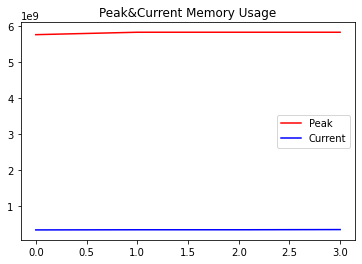

In [ ]:
#read the path to the target directory under user's google drive (modify the path /content/drive/MyDrive/path/to/ here before running)
query_file = glob.glob("/content/drive/MyDrive/models/transformer/Test/logging_query*.txt")
key_file = glob.glob("/content/drive/MyDrive/models/transformer/Test/logging_key*.txt")
value_file = glob.glob("/content/drive/MyDrive/models/transformer/Test/logging_value*.txt")
bias_file = glob.glob("/content/drive/MyDrive/models/transformer/Test/logging_bias*.txt")
#read the file and parse it to tensor before sending to the flat function
peak = []
curr = []
t = []
#ask for user input
batch1 = int(input("Enter Batch Granularity Level1:"))
batch2 = int(input("Enter Batch Granularity Level2:"))
head1 = int(input("Enter Head Granularity Level1:"))
head2 = int(input("Enter Head Granularity Level2:"))
length = int(input("Enter Length Granularity Level:"))
tf.config.experimental.reset_memory_stats('GPU:0')
start_time = time.time()
#write result to a temporary file
path = "/content/drive/MyDrive/models/transformer/result.txt"
f = open(path, 'a')
grastr = "%d*%d*%d*%d*%d " % (batch1, batch2, head1, head2, length)
for idx, file in enumerate(query_file):
  query = tf.io.parse_tensor(tf.io.read_file(file), out_type=tf.float32)
  key = tf.io.parse_tensor(tf.io.read_file(file), out_type=tf.float32)
  value = tf.io.parse_tensor(tf.io.read_file(file), out_type=tf.float32)
  bias = tf.io.parse_tensor(tf.io.read_file(file), out_type=tf.float32)
  print(query.shape)
  peakOld, currOld, peakCurr, currCurr, stoptime = FlatDataflow(idx, query, key, value, bias, batch_granularity_level1=batch1, batch_granularity_level2=batch2,
                                                      head_granularity_level1=head1, head_granularity_level2=head2, length_granularity_level=length)
  peak.append(peakCurr)
  curr.append(currCurr)
  t.append(stoptime - start_time)
dir = {"granularity": grastr, "peak": sum(peak)/len(peak), "curr": sum(curr)/len(curr), "time": t[-1]/len(t)}
f.write(json.dumps(dir))
f.write("\n")
f.close()
iteration = np.arange(len(peak))
plt.plot(iteration,peak,'r',label="Peak")
plt.plot(iteration,curr,'b',label='Current')
plt.legend()
plt.title("Peak&Current Memory Usage")

In [ ]:
f = open(path, 'r')
file_contents = f.read()
print (file_contents)
f.close()

{"granularity": "1*1*1*1*32 ", "peak": 144640.0, "curr": 85760.0, "time": 0.707266092300415}
{"granularity": "1*1*1048*512*64 ", "peak": 111360.0, "curr": 85248.0, "time": 0.5663280487060547}
{"granularity": "16384*16384*16484*1*1 ", "peak": 166144.0, "curr": 133376.0, "time": 0.2881624698638916}
{"granularity": "1*1*4096*2048*64 ", "peak": 143616.0, "curr": 86016.0, "time": 0.6527509689331055}
{"granularity": "10*10*1*1*1 ", "peak": 112896.0, "curr": 88576.0, "time": 0.29667139053344727}
{"granularity": "10*10*1*1*1 ", "peak": 144128.0, "curr": 101888.0, "time": 0.0417180061340332}
{"granularity": "1*1*1*1*1 ", "peak": 145664.0, "curr": 91392.0, "time": 0.30886030197143555}
{"granularity": "1*10*2*1*1 ", "peak": 163328.0, "curr": 87552.0, "time": 0.28141069412231445}
{"granularity": "1*1*16*8*64 ", "peak": 4560158720.0, "curr": 1738558464.0, "time": 1.486714243888855}
{"granularity": "1*1*64*32*64 ", "peak": 5804918784.0, "curr": 341049088.0, "time": 2.677780508995056}



In [ ]:
os.remove("/content/drive/MyDrive/models/transformer/result.txt")

In [ ]:
tf.config.experimental.reset_memory_stats('GPU:0')